In [2]:
import torch
from ptbxlae.modeling.convolutionalVAE import ConvolutionalEcgVAE

* PTB-XL Autoencoder *


In [3]:
torch.no_grad()
m = ConvolutionalEcgVAE.load_from_checkpoint('../cache/savedmodels/mcc-epoch=013-val_loss=0.009974.ckpt')
m.eval()

ConvolutionalEcgVAE(
  (encoder): ConvolutionalEcgEncoder(
    (net): Sequential(
      (0): Conv1d(2, 4, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv1d(4, 8, kernel_size=(7,), stride=(2,), padding=(3,))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=10000, out_features=500, bias=True)
      (8): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): ConvolutionalEcgDecoder(
    (net): Sequential(
      (0): Linear(in_features=500, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=500, out_features=10000, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Unflatten(dim=1, unflattened_size=(16, 625))
      (5): ConvTranspose1d(16, 8, kernel_size=(7,), stride=(2,), padding=(3,), output_paddi

In [4]:
from ptbxlae.dataprocessing.ptbxlDS import PtbxlSigWithRpeaksDS

SAMPLE_IDX = 929

ds = PtbxlSigWithRpeaksDS(root_folder="../data", lowres=False, stacked=True)
sig = ds[SAMPLE_IDX]
sig.shape

torch.Size([2, 5000])

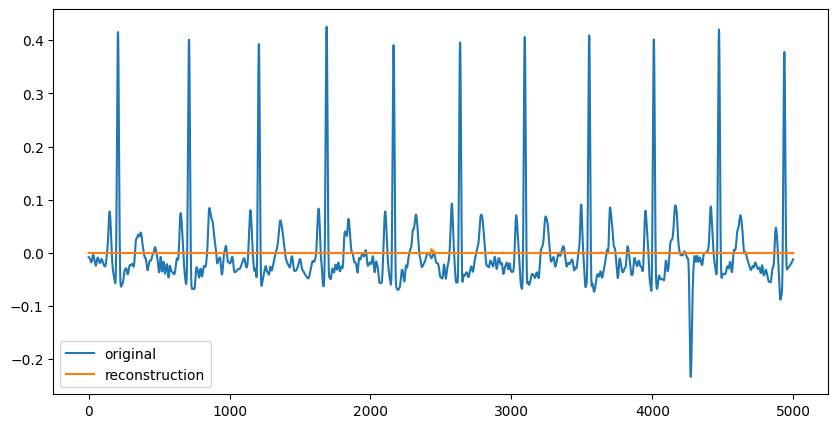

In [15]:
# from ptbxlae.dataprocessing import plot_raw_data

# # before
# plot_raw_data(sig[0:12], {'fs': 500})

import matplotlib.pyplot as plt

x = range(0, sig.shape[1])

SAMPLE_IDX = 5839
CHANNEL = 0

latent_representation = m.encode(ds[SAMPLE_IDX].unsqueeze(0).to('cuda'))
# reconstruction = m.generate(latent_representation, smoothing_iterations=10).squeeze().detach().cpu()
reconstruction = m.decode(latent_representation).squeeze().detach().cpu()
orig_plot = ds[SAMPLE_IDX][CHANNEL]
recon_plot = reconstruction[CHANNEL]

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
ax.plot(x, orig_plot, label='original')
ax.plot(x, recon_plot, label='reconstruction')
plt.legend(loc='best')